## Assignment: Dyna-Q and Dyna-Q+

 1. Implement the Dyna-Q and Dyna-Q+ algorithms.
 1. Compare the performance of an environment which changes to become 'better' than it was before, that is, the task becomes easier.

### The Shortcut Maze Environment

In this maze environment, the goal is to reach the goal state (G) as fast as possible from the starting state (S). There are four actions – up, down, right, left – which take the agent deterministically from a state to the corresponding neighboring states, except when movement is blocked by a wall (denoted by grey) or the edge of the maze, in which case the agent remains where it is. The reward is +1 on reaching the goal state, 0 otherwise. On reaching the goal state G, the agent returns to the start state S to being a new episode. This is a discounted, episodic task with $\gamma = 0.95$.

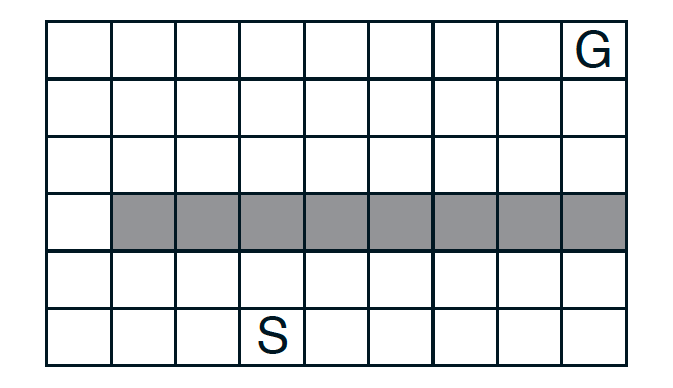

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm

from rl_glue import RLGlue
from agent import BaseAgent
from maze_env import ShortcutMazeEnvironment

os.makedirs('results', exist_ok=True)

In [22]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

### Section 1: Dyna-Q
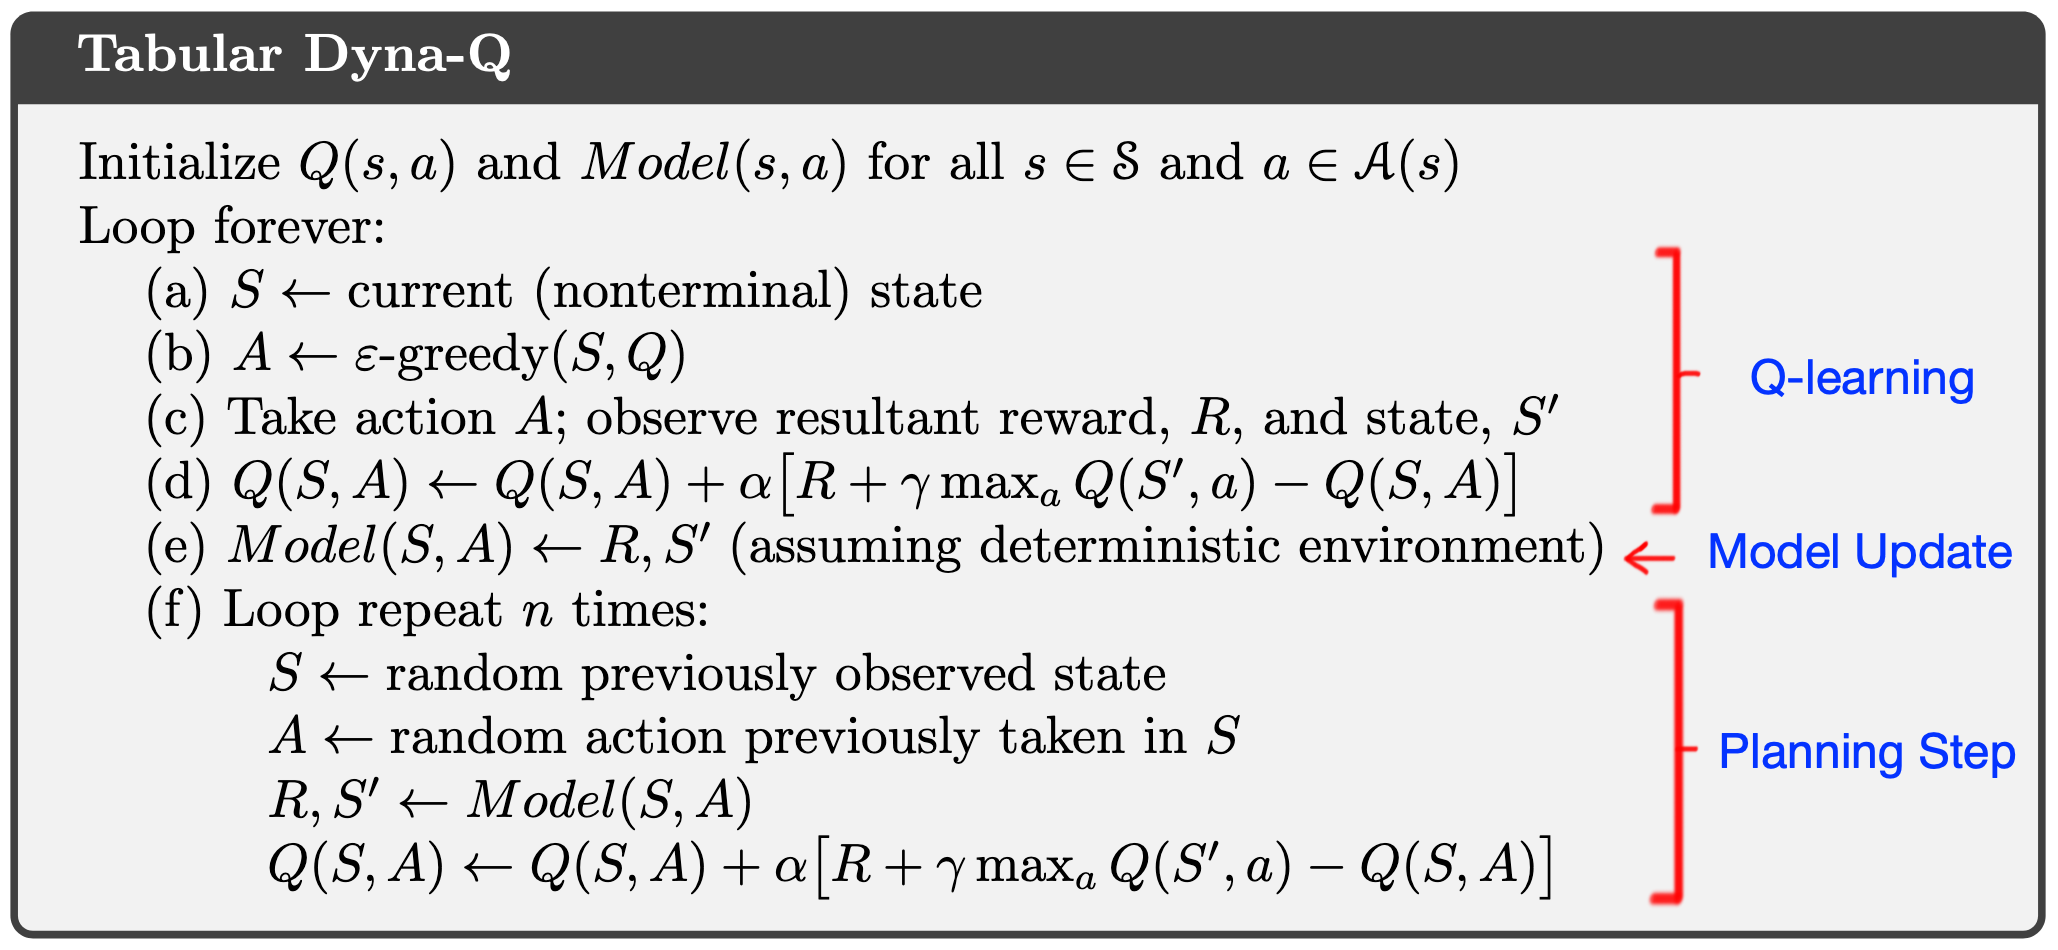

Dyna-Q involves four basic steps:

 1. Action selection: given an observation, select an action to be performed (here, using the $\epsilon$-greedy method).
 1. Direct RL: using the observed next state and reward, update the action values (here, using one-step tabular Q-learning).
 1. Model learning: using the observed next state and reward, update the model (here, updating a table as the environment is assumed to be deterministic).
 1. Planning: update the action values by generating $n$ simulated experiences using certain starting states and actions (here, using the random-sample one-step tabular Q-planning method). This is also known as the 'Indirect RL' step. The process of choosing the state and action to simulate an experience with is known as 'search control'.

In [23]:
class DynaQAgent(BaseAgent):

    def agent_init(self, agent_info):
        """Setup for the agent called when the experiment first starts.

        Args:
            agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
            {
                num_states (int): The number of states,
                num_actions (int): The number of actions,
                epsilon (float): The parameter for epsilon-greedy exploration,
                step_size (float): The step-size,
                discount (float): The discount factor,
                planning_steps (int): The number of planning steps per environmental interaction

                random_seed (int): the seed for the RNG used in epsilon-greedy
                planning_random_seed (int): the seed for the RNG used in the planner
            }
        """

        # First, we get the relevant information from agent_info 
        # NOTE: we use np.random.RandomState(seed) to set the two different RNGs
        # for the planner and the rest of the code
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        # Next, we initialize the attributes required by the agent, e.g., q_values, model, etc.
        # A simple way to implement the model is to have a dictionary of dictionaries, 
        #        mapping each state to a dictionary which maps actions to (reward, next state) tuples.
        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {} # model is a dictionary of dictionaries, which maps states to actions to 
                        # (reward, next_state) tuples

In [24]:
%%add_to DynaQAgent

# [GRADED]

def update_model(self, past_state, past_action, state, reward):
    """updates the model 
    
    Args:
        past_state       (int): s
        past_action      (int): a
        state            (int): s'
        reward           (int): r
    Returns:
        Nothing
    """
    # Update the model with the (s,a,s',r) tuple (1~4 lines)
    
    ### START CODE HERE ###
    if past_state not in self.model:
        self.model[past_state] = {}
    self.model[past_state][past_action] = (state, reward)
    ### END CODE HERE ###

In [25]:
# Do not modify this cell!

## Test code for update_model() ##

actions = []
agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "random_seed": 0,
              "planning_random_seed": 0}
test_agent = DynaQAgent()
test_agent.agent_init(agent_info)
test_agent.update_model(0,2,0,1)
test_agent.update_model(2,0,1,1)
test_agent.update_model(0,3,1,2)
print("Model: \n", test_agent.model)

Model: 
 {0: {2: (0, 1), 3: (1, 2)}, 2: {0: (1, 1)}}


In [26]:
%%add_to DynaQAgent

# [GRADED]

def planning_step(self):
    """performs planning, i.e. indirect RL.

    Args:
        None
    Returns:
        Nothing
    """
    
    # The indirect RL step:
    # - Choose a state and action from the set of experiences that are stored in the model. (~2 lines)
    # - Query the model with this state-action pair for the predicted next state and reward.(~1 line)
    # - Update the action values with this simulated experience.                            (2~4 lines)
    # - Repeat for the required number of planning steps.
    #
    # Note that the update equation is different for terminal and non-terminal transitions. 
    # To differentiate between a terminal and a non-terminal next state, assume that the model stores
    # the terminal state as a dummy state like -1
    #
    # Important: remember you have a random number generator 'planning_rand_generator' as 
    #     a part of the class which you need to use as self.planning_rand_generator.choice()
    #     For the sake of reproducibility and grading, *do not* use anything else like 
    #     np.random.choice() for performing search control.

    ### START CODE HERE ###
    for _ in range(self.planning_steps):
        past_state = self.planning_rand_generator.choice(list(self.model.keys()))
        past_action = self.planning_rand_generator.choice(list(self.model[past_state].keys()))
        state, reward = self.model[past_state][past_action]
        if state != -1:
            self.q_values[past_state][past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[past_state][past_action])
        else:
            self.q_values[past_state][past_action] += self.step_size * (reward - self.q_values[past_state][past_action])
    ### END CODE HERE ###

In [27]:
# Do not modify this cell!

## Test code for planning_step() ##

actions = []
agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "planning_steps": 4,
              "random_seed": 0,
              "planning_random_seed": 5}
test_agent = DynaQAgent()
test_agent.agent_init(agent_info)
test_agent.update_model(0,2,1,1)
test_agent.update_model(2,0,1,1)
test_agent.update_model(0,3,0,1)
test_agent.update_model(0,1,-1,1)
test_agent.planning_step()
print("Model: \n", test_agent.model)
print("Action-value estimates: \n", test_agent.q_values)

Model: 
 {0: {2: (1, 1), 3: (0, 1), 1: (-1, 1)}, 2: {0: (1, 1)}}
Action-value estimates: 
 [[0.  0.1 0.  0.2]
 [0.  0.  0.  0. ]
 [0.1 0.  0.  0. ]]


In [28]:
%%add_to DynaQAgent

# Do not modify this cell!

def argmax(self, q_values):
    """argmax with random tie-breaking
    Args:
        q_values (Numpy array): the array of action values
    Returns:
        action (int): an action with the highest value
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return self.rand_generator.choice(ties)

def choose_action_egreedy(self, state):
    """returns an action using an epsilon-greedy policy w.r.t. the current action-value function.

    Important: assume you have a random number generator 'rand_generator' as a part of the class
                which you can use as self.rand_generator.choice() or self.rand_generator.rand()

    Args:
        state (List): coordinates of the agent (two elements)
    Returns:
        The action taken w.r.t. the aforementioned epsilon-greedy policy
    """

    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.choice(self.actions)
    else:
        values = self.q_values[state]
        action = self.argmax(values)

    return action

In [29]:
%%add_to DynaQAgent

# [GRADED]

def agent_start(self, state):
    """The first method called when the experiment starts, 
    called after the environment starts.
    Args:
        state (Numpy array): the state from the
            environment's env_start function.
    Returns:
        (int) the first action the agent takes.
    """
    
    # given the state, select the action using self.choose_action_egreedy()), 
    # and save current state and action (~2 lines)
    ### self.past_state = ?
    ### self.past_action = ?

    ### START CODE HERE ###
    action = self.choose_action_egreedy(state)
    
    self.past_state = state
    self.past_action = action
    ### END CODE HERE ###
    
    return self.past_action

def agent_step(self, reward, state):
    """A step taken by the agent.

    Args:
        reward (float): the reward received for taking the last action taken
        state (Numpy array): the state from the
            environment's step based on where the agent ended up after the
            last step
    Returns:
        (int) The action the agent takes given this state.
    """
    
    # - Direct-RL step (~1-3 lines)
    # - Model Update step (~1 line)
    # - `planning_step` (~1 line)
    # - Action Selection step (~1 line)
    # Save the current state and action before returning the action to be performed. (~2 lines)

    ### START CODE HERE ###
    self.q_values[self.past_state][self.past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[self.past_state][self.past_action])
    
    self.update_model(self.past_state, self.past_action, state, reward)
    
    self.planning_step()
    
    action = self.choose_action_egreedy(state)
    
    self.past_state = state
    self.past_action = action
    ### END CODE HERE ###
    
    return self.past_action

def agent_end(self, reward):
    """Called when the agent terminates.

    Args:
        reward (float): the reward the agent received for entering the
            terminal state.
    """
    
    # - Direct RL update with this final transition (1~2 lines)
    # - Model Update step with this final transition (~1 line)
    # - One final `planning_step` (~1 line)
    #
    # Note: the final transition needs to be handled carefully. Since there is no next state, 
    #       you will have to pass a dummy state (like -1), which you will be using in the planning_step() to 
    #       differentiate between updates with usual terminal and non-terminal transitions.

    ### START CODE HERE ###
    self.q_values[self.past_state][self.past_action] += self.step_size * (reward - self.q_values[self.past_state][self.past_action])
    
    self.update_model(self.past_state, self.past_action, -1, reward)
    
    self.planning_step()
    ### END CODE HERE ###

In [30]:
# Do not modify this cell!

## Test code for agent_start() ##

agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "random_seed": 0,
              "planning_random_seed": 0}
test_agent = DynaQAgent()
test_agent.agent_init(agent_info)
action = test_agent.agent_start(0)
print("Action:", action)
print("Model: \n", test_agent.model)
print("Action-value estimates: \n", test_agent.q_values)

Action: 1
Model: 
 {}
Action-value estimates: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [31]:
# Do not modify this cell!

## Test code for agent_step() ##

actions = []
agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "planning_steps": 2,
              "random_seed": 0,
              "planning_random_seed": 0}
test_agent = DynaQAgent()
test_agent.agent_init(agent_info)
actions.append(test_agent.agent_start(0))
actions.append(test_agent.agent_step(1,2))
actions.append(test_agent.agent_step(0,1))
print("Actions:", actions)
print("Model: \n", test_agent.model)
print("Action-value estimates: \n", test_agent.q_values)

Actions: [1, 3, 1]
Model: 
 {0: {1: (2, 1)}, 2: {3: (1, 0)}}
Action-value estimates: 
 [[0.     0.3439 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]


In [32]:
# Do not modify this cell!

## Test code for agent_end() ##

actions = []
agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "planning_steps": 2,
              "random_seed": 0,
              "planning_random_seed": 0}
test_agent = DynaQAgent()
test_agent.agent_init(agent_info)
actions.append(test_agent.agent_start(0))
actions.append(test_agent.agent_step(1,2))
actions.append(test_agent.agent_step(0,1))
test_agent.agent_end(1)
print("Actions:", actions)
print("Model: \n", test_agent.model)
print("Action-value Estimates: \n", test_agent.q_values)

Actions: [1, 3, 1]
Model: 
 {0: {1: (2, 1)}, 2: {3: (1, 0)}, 1: {1: (-1, 1)}}
Action-value Estimates: 
 [[0.      0.41051 0.      0.     ]
 [0.      0.1     0.      0.     ]
 [0.      0.      0.      0.01   ]]


In [33]:
# Do not modify this cell!

def run_experiment(env, agent, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_episodes = exp_parameters['num_episodes']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = env_parameters                     
    agent_info = {"num_states" : agent_parameters["num_states"],  # We pass the agent the information it needs. 
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    all_averages = np.zeros((len(planning_steps_all), num_runs, num_episodes)) # for collecting metrics 
    log_data = {'planning_steps_all' : planning_steps_all}                     # that shall be plotted later

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 0.5')                    # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  

        for i in tqdm(range(num_runs)):

            agent_info['random_seed'] = i
            agent_info['planning_random_seed'] = i

            rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            for j in range(num_episodes):

                rl_glue.rl_start()                # We start an episode. Here we aren't using rl_glue.rl_episode()
                                                  # like the other assessments because we'll be requiring some 
                is_terminal = False               # data from within the episodes in some of the experiments here 
                num_steps = 0
                while not is_terminal:
                    reward, _, action, is_terminal = rl_glue.rl_step()  # The environment and agent take a step 
                    num_steps += 1                                      # and return the reward and action taken.

                all_averages[idx][i][j] = num_steps

    log_data['all_averages'] = all_averages
    np.save("results/Dyna-Q_planning_steps", log_data)
    

def plot_steps_per_episode(file_path):

    data = np.load(file_path).item()
    all_averages = data['all_averages']
    planning_steps_all = data['planning_steps_all']

    for i, planning_steps in enumerate(planning_steps_all):
        plt.plot(np.mean(all_averages[i], axis=0), label='Planning steps = '+str(planning_steps))

    plt.legend(loc='upper right')
    plt.xlabel('Episodes')
    plt.ylabel('Steps\nper\nepisode', rotation=0, labelpad=40)
    plt.axhline(y=16, linestyle='--', color='grey', alpha=0.4)
    plt.show()

In [35]:


# Do NOT modify the parameter settings.

# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_episodes" : 40,                 # The number of episodes per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.125,
    "planning_steps" : [0, 5, 50]       # The list of planning_steps we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_steps_per_episode('results/Dyna-Q_planning_steps.npy')   
shutil.make_archive('results', 'zip', 'results');



  0%|          | 0/30 [00:00<?, ?it/s]

Planning steps :  0


  0%|          | 0/30 [00:00<?, ?it/s]

Planning steps :  5


  0%|          | 0/30 [00:00<?, ?it/s]

Planning steps :  50


100%|██████████| 30/30 [00:44<00:00,  1.50s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'results/Dyna-Q_planning_steps.npy'